### **Step 1: Download Dataset**

##### Install *`kaggle`* Package

In [1]:
!pip install kaggle

!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                                 title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset                         📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          16263        339  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024                   Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51          12258        257  1.0              
ihelon/coffee-sales                                                 Coffee Sales                                         10KB  2024-07-03 20:04:43           4127         73  1.0              
suchintikasarkar/sentiment-analysis-for-

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Fetch and Unzip Dataset

In [3]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.02G/1.04G [00:19<00:00, 62.1MB/s]
100% 1.04G/1.04G [00:19<00:00, 57.6MB/s]


In [4]:
!unzip *.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

### **Step 2: Data Preprocessing**

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

- Define the *`Vocabulary Class`* for apply mapping words to indices 

In [8]:
# Define the Vocabulary Class
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.add_word("<PAD>")
        self.add_word("<SOS>")
        self.add_word("<EOS>")
        self.add_word("<unk>")

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __str__(self):
        return str(self.idx2word) + "\n" + str(self.word2idx)

    def __len__(self):
        return len(self.word2idx)

    def __call__(self, word):
        if not word.lower() in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word.lower()]

    def word_to_index(self, word):
        return self.word2idx.get(word, self.word2idx['<unk>'])

    def index_to_word(self, index):
        return self.idx2word.get(index, '<unk>')


- Define the *`Flickr8kDataset Class`* for:
    1. opening resizing and transforming images 
    2. loading caption, adding `<SOS>` & `<EOS>`,tokenizing and map its words to indices
    3. move image and caption to `torch.tensor`

In [9]:
# Define the Flickr8kDataset class
class Flickr8kDataset(Dataset):
    def __init__(self, df, images_folder, transform=None):
        self.captions = df
        self.images_folder = images_folder
        self.transform = transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, index):
        img_id = self.captions.iloc[index]['image']
        img_path = os.path.join(self.images_folder, img_id)
        image = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)

        caption = self.captions.iloc[index]['caption']
        tokens = word_tokenize(caption.lower())

        numericalized_caption = [vocab.word2idx["<SOS>"]]
        for word in tokens:
            numericalized_caption.append(vocab.word_to_index(word))
        numericalized_caption.append(vocab.word2idx["<EOS>"])

        return image, torch.tensor(numericalized_caption)

### **Step 3: Define Image Captioning Model**

- *`class encoderCNN`*
    1. pretrained resnet18 layer (as a feature extractor)
    2. linear layer
    3. batch normalization layer (to prevent overfitting)

In [10]:
# CNN Model
class encoderCNN(nn.Module):
    def __init__(self, trainCNN=False):
        super(encoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, 256)
        self.bn = nn.BatchNorm1d(256, momentum=0.01)

        # Freeze all layers except the final fully connected layer
        for param in self.feature_extractor.parameters():
            param.requires_grad = trainCNN

    def forward(self, images):
        features = self.feature_extractor(images)
        features = features.view(features.size(0), -1)
        features = self.bn(self.fc(features))
        return features

- *`class decoderRNN`*
    1. embedding layer (to presenting words by vectors)
    2. dropout layer (to prevent overfitting)
    3. LSTM layer
    4. linear layer

In [11]:
# LSTM Model
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size + 256, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        features = features.unsqueeze(1).repeat(1, embeddings.size(1), 1)
        embeddings = torch.cat((features, embeddings), 2)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

- **`class ImageCaptioningModel`**
    1. *CNN Encoder* (for extracting features from images)
    2. *LSTM Decoder* (for generating caption depend on features)

In [12]:
# Combine models
class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.cnn = cnn
        self.decoder = decoder

    def forward(self, images, captions):
        features = self.cnn(images)
        outputs = self.decoder(features, captions)
        return outputs

In [13]:
# Define the preprocessing steps for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load Flickr8k dataset, preprocess images and captions
captions_file = '/content/captions.txt'
images_folder = '/content/Images'
captions = pd.read_csv(captions_file, sep=',', header=None, skiprows=1, names=['image', 'caption'])

# splitting dataset to train and test data
train_data, test_data = train_test_split(captions, test_size=0.2, random_state=42)

train_dataset = Flickr8kDataset(train_data, images_folder, transform=transform)
test_dataset = Flickr8kDataset(test_data, images_folder, transform=transform)


In [14]:
# Create the Vocabulary object and build the vocabulary
vocab = Vocabulary()
for caption in captions['caption']:
    for word in caption.lower().split():
        if word not in [".", ",", "-", ";", "!"]:
            vocab.add_word(word)

print(vocab)
print("vocab size:", len(vocab))
print("index of 'apple':", vocab.word_to_index("apple"))
print("word in index 2024:", vocab.index_to_word(2024))

{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<unk>', 4: 'a', 5: 'child', 6: 'in', 7: 'pink', 8: 'dress', 9: 'is', 10: 'climbing', 11: 'up', 12: 'set', 13: 'of', 14: 'stairs', 15: 'an', 16: 'entry', 17: 'way', 18: 'girl', 19: 'going', 20: 'into', 21: 'wooden', 22: 'building', 23: 'little', 24: 'playhouse', 25: 'the', 26: 'to', 27: 'her', 28: 'cabin', 29: 'black', 30: 'dog', 31: 'and', 32: 'spotted', 33: 'are', 34: 'fighting', 35: 'tri-colored', 36: 'playing', 37: 'with', 38: 'each', 39: 'other', 40: 'on', 41: 'road', 42: 'white', 43: 'brown', 44: 'spots', 45: 'staring', 46: 'at', 47: 'street', 48: 'two', 49: 'dogs', 50: 'different', 51: 'breeds', 52: 'looking', 53: 'pavement', 54: 'moving', 55: 'toward', 56: 'covered', 57: 'paint', 58: 'sits', 59: 'front', 60: 'painted', 61: 'rainbow', 62: 'hands', 63: 'bowl', 64: 'sitting', 65: 'large', 66: 'small', 67: 'grass', 68: 'plays', 69: 'fingerpaints', 70: 'canvas', 71: 'it', 72: 'there', 73: 'pigtails', 74: 'painting', 75: 'young', 76: 'outside',

- Define *`custom collate function`*
We should apply padding to captions in each batch to have same length. So we handle it by pass this function to dataloader. 
But it's important to doing padding by a special character (`<PAD>`) to doesn't have any affect on Back Propagation.

In [15]:
def custom_collate_fn(batch):
    images, captions = zip(*batch)
    images = torch.stack(images, dim=0)
    captions = pad_sequence(captions, batch_first=True, padding_value=vocab.word2idx['<PAD>'])
    return images, captions

# Define the data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

In [16]:
# Hyperparameters
vocab_size = len(vocab)
embed_size = 300
hidden_size = 256
num_layers = 1
learning_rate = 3e-4

cnn = encoderCNN()
lstm = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
model = ImageCaptioningModel(cnn, lstm).to(device)

# Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx['<PAD>'])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 184MB/s]


### **Step 4: Training The Model (Freeze ResNet18)**

In [17]:
# Use the dataloader in the training loop
num_epochs=5

train_losses=[]
test_losses=[]
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss=0
    test_loss=0

    print(f'Training...', end="\t")
    model.train()
    for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader)):
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        outputs = model(imgs, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()


    print(f'Validation...', end="\t")
    model.eval()
    with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(test_loader), total=len(test_loader)):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

            test_loss += loss.item()

    avg_train_loss = train_loss/len(train_loader)
    avg_test_loss = test_loss/len(test_loader)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    print(f'train loss = {avg_train_loss}\t test loss = {avg_test_loss}\n')

Epoch 1/5
Training...	

100%|██████████| 1012/1012 [04:28<00:00,  3.77it/s]


Validation...	

100%|██████████| 253/253 [01:01<00:00,  4.10it/s]


train loss = 4.323956755074588	 test loss = 3.613874354381335

Epoch 2/5
Training...	

100%|██████████| 1012/1012 [04:30<00:00,  3.74it/s]


Validation...	

100%|██████████| 253/253 [01:04<00:00,  3.94it/s]


train loss = 3.4470815380571387	 test loss = 3.2978088299747514

Epoch 3/5
Training...	

100%|██████████| 1012/1012 [04:28<00:00,  3.76it/s]


Validation...	

100%|██████████| 253/253 [01:03<00:00,  3.98it/s]


train loss = 3.1816021246401216	 test loss = 3.1327410648933984

Epoch 4/5
Training...	

100%|██████████| 1012/1012 [04:27<00:00,  3.78it/s]


Validation...	

100%|██████████| 253/253 [01:07<00:00,  3.75it/s]


train loss = 3.0122338055150784	 test loss = 3.0289415436771074

Epoch 5/5
Training...	

100%|██████████| 1012/1012 [04:28<00:00,  3.77it/s]


Validation...	

100%|██████████| 253/253 [01:05<00:00,  3.87it/s]

train loss = 2.886738340374038	 test loss = 2.9631272248128657



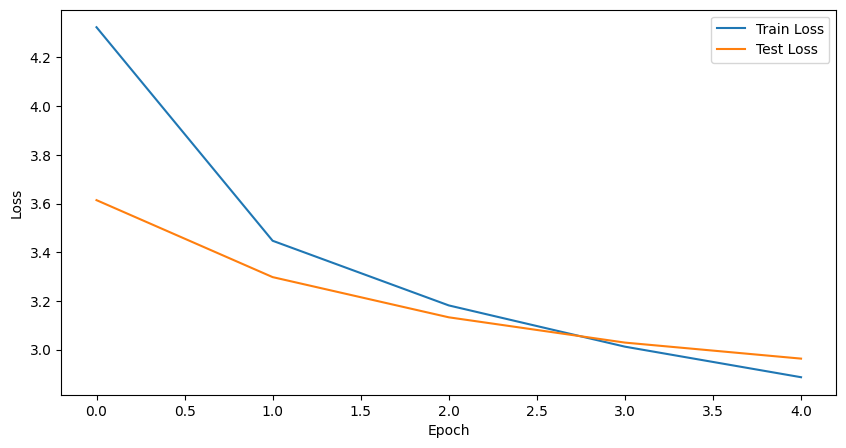

In [18]:
# plotting losses during the training 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### **Step 5: Predicting 5 Random Test Images**

Test 1: 


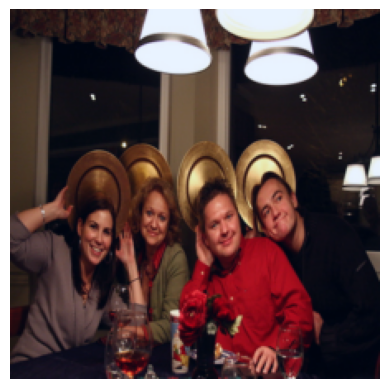

Predicted Caption: a women in a are for a picture <unk> a crowd <unk> <unk> <unk> him picture <unk> <EOS>
Original Caption: <SOS> two men and women pose for a camera with large gold plates held behind their heads <unk> <EOS>

Test 2: 


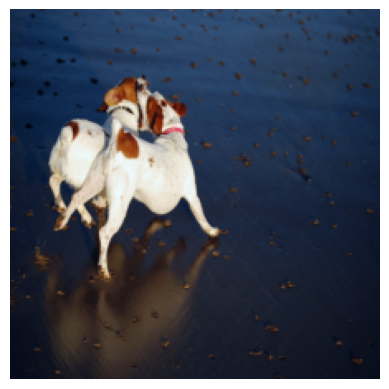

Predicted Caption: two are a other <unk> <EOS>
Original Caption: <SOS> dogs chase each other <unk> <EOS>

Test 3: 


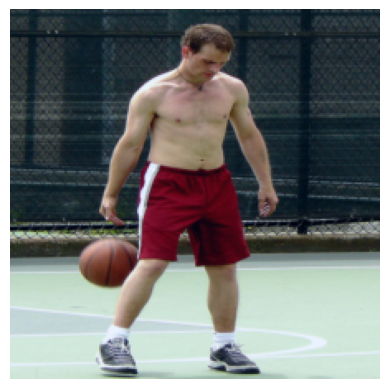

Predicted Caption: a man in a shirt is basketball <unk> <EOS>
Original Caption: <SOS> a man with no shirt plays basketball <unk> <EOS>

Test 4: 


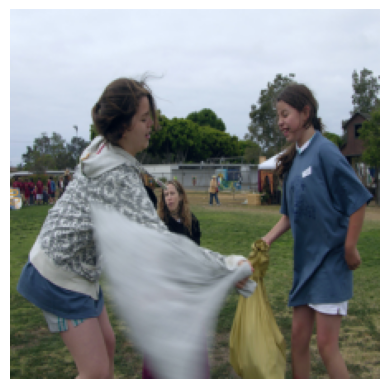

Predicted Caption: a girls are in a <unk> <unk> a field <unk> <EOS>
Original Caption: <SOS> two girls playing with plastic bags in a park <unk> <EOS>

Test 5: 


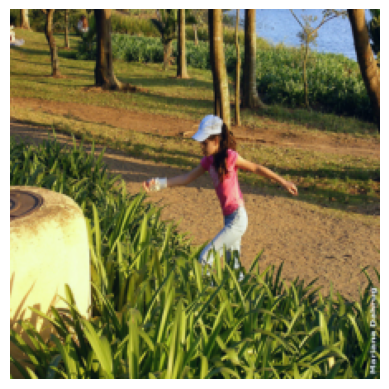

Predicted Caption: a boy in on a a a grass <unk> is a tree <unk> <unk> a tree <unk> <EOS>
Original Caption: <SOS> a girl begins to wade through deep grass that covers a stone structure on a coastline <unk> <EOS>



In [19]:
model.eval()
total_samples = len(test_loader.dataset)

# Select 5 random indices
random_indices = random.sample(range(total_samples), 5)

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        image, caption = test_loader.dataset[idx]
        image, caption = image.unsqueeze(0).to(device), caption.unsqueeze(0).to(device)
        output = model(image, caption[:, :-1])
        _, predicted_indices = output.max(2)

        # Convert indices to words
        original_caption = [list(vocab.word2idx.keys())[list(vocab.word2idx.values()).index(idx)] for idx in caption[0].tolist() if idx not in [vocab.word2idx['<PAD>']]]
        predicted_caption = [list(vocab.word2idx.keys())[list(vocab.word2idx.values()).index(idx)] for idx in predicted_indices[0].tolist() if idx not in [vocab.word2idx['<PAD>']]]

        print(f'Test {i+1}: ')

        img = image[0]
        img_arr = img.cpu().numpy()
        img_arr = np.transpose(img_arr, (1,2,0))

        img_norm = (255*(img_arr - np.min(img_arr))/np.ptp(img_arr)).astype(int)

        plt.imshow(img_norm)
        plt.axis('off')
        plt.show()

        print(f'Predicted Caption: {" ".join(predicted_caption)}')
        print(f'Original Caption: {" ".join(original_caption)}\n')

### **Step 6: Training The Model2 (Unfreeze ResNet18)**

In [20]:
trainable_cnn = encoderCNN(trainCNN=True)
lstm = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
model2 = ImageCaptioningModel(trainable_cnn, lstm).to(device)

# Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<PAD>"])
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [21]:
# Use the dataloader in the training loop

train_losses=[]
test_losses=[]
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_loss=0
    test_loss=0

    print(f'Training...', end="\t")
    model2.train()
    for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader)):
        imgs = imgs.to(device)
        captions = captions.to(device)

        optimizer2.zero_grad()
        outputs = model2(imgs, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        loss.backward()
        optimizer2.step()

        train_loss += loss.item()


    print(f'Validation...', end="\t")
    model2.eval()
    with torch.no_grad():
        for idx, (imgs, captions) in tqdm(enumerate(test_loader), total=len(test_loader)):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model2(imgs, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))

            test_loss += loss.item()

    avg_train_loss = train_loss/len(train_loader)
    avg_test_loss = test_loss/len(test_loader)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    print(f'train loss = {avg_train_loss}\t test loss = {avg_test_loss}\n')

Epoch 1/5
Training...	

100%|██████████| 1012/1012 [05:15<00:00,  3.20it/s]


Validation...	

100%|██████████| 253/253 [01:02<00:00,  4.05it/s]


train loss = 4.369337227033532	 test loss = 3.6922230192795102

Epoch 2/5
Training...	

100%|██████████| 1012/1012 [05:12<00:00,  3.24it/s]


Validation...	

100%|██████████| 253/253 [01:04<00:00,  3.92it/s]


train loss = 3.508736719255862	 test loss = 3.3466247372005298

Epoch 3/5
Training...	

100%|██████████| 1012/1012 [05:14<00:00,  3.22it/s]


Validation...	

100%|██████████| 253/253 [01:04<00:00,  3.93it/s]


train loss = 3.221485647759419	 test loss = 3.1582161975001157

Epoch 4/5
Training...	

100%|██████████| 1012/1012 [05:12<00:00,  3.24it/s]


Validation...	

100%|██████████| 253/253 [01:07<00:00,  3.77it/s]


train loss = 3.026775168807139	 test loss = 3.04202312254623

Epoch 5/5
Training...	

100%|██████████| 1012/1012 [05:13<00:00,  3.22it/s]


Validation...	

100%|██████████| 253/253 [01:01<00:00,  4.10it/s]

train loss = 2.8822607673675176	 test loss = 2.943397397580354



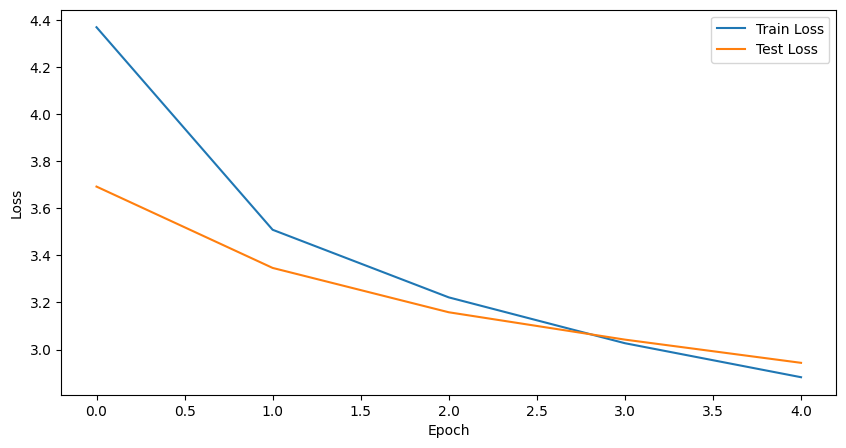

In [22]:
# plotting losses during the training 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test 1: 


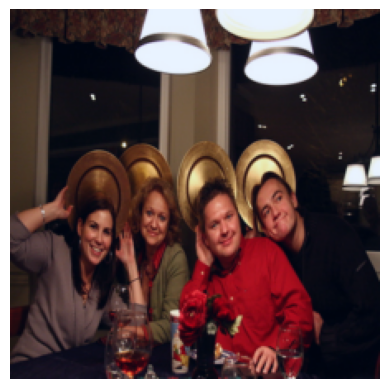

Predicted Caption: two women are a are for a picture <unk> a camera <unk> <unk> <unk> them hands <unk> <EOS>
Original Caption: <SOS> two men and women pose for a camera with large gold plates held behind their heads <unk> <EOS>

Test 2: 


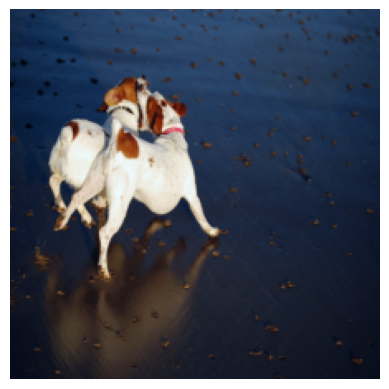

Predicted Caption: two running a other on <EOS>
Original Caption: <SOS> dogs chase each other <unk> <EOS>

Test 3: 


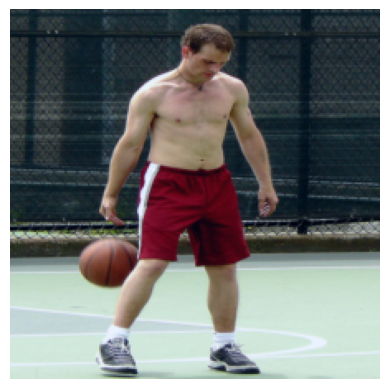

Predicted Caption: a man in a shirt is in <unk> <EOS>
Original Caption: <SOS> a man with no shirt plays basketball <unk> <EOS>

Test 4: 


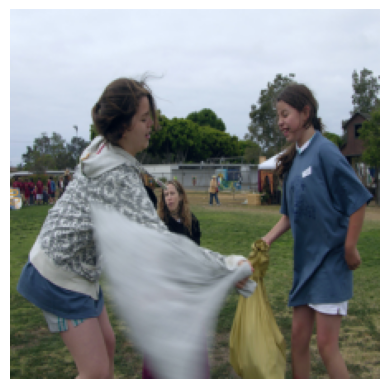

Predicted Caption: two children are in a hair <unk> the field <unk> <EOS>
Original Caption: <SOS> two girls playing with plastic bags in a park <unk> <EOS>

Test 5: 


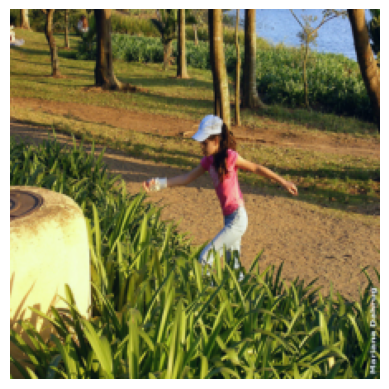

Predicted Caption: a little in in a a a grass <unk> is <unk> tree <unk> <unk> a grassy <unk> <EOS>
Original Caption: <SOS> a girl begins to wade through deep grass that covers a stone structure on a coastline <unk> <EOS>



In [23]:
# prediction of 5 previous random images
model2.eval()

with torch.no_grad():
    for i, idx in enumerate(random_indices):
        image, caption = test_loader.dataset[idx]
        image = image.unsqueeze(0).to(device)
        caption = caption.unsqueeze(0).to(device)
        output = model2(image, caption[:, :-1])
        _, predicted_indices = output.max(2)

        # Convert indices to words
        original_caption = [list(vocab.word2idx.keys())[list(vocab.word2idx.values()).index(idx)] for idx in caption[0].tolist() if idx not in [vocab.word2idx['<PAD>']]]
        predicted_caption = [list(vocab.word2idx.keys())[list(vocab.word2idx.values()).index(idx)] for idx in predicted_indices[0].tolist() if idx not in [vocab.word2idx['<PAD>']]]

        print(f'Test {i+1}: ')

        img = image[0]
        img_arr = img.cpu().numpy()
        img_arr = np.transpose(img_arr, (1,2,0))

        img_norm = (255*(img_arr - np.min(img_arr))/np.ptp(img_arr)).astype(int)

        plt.imshow(img_norm)
        plt.axis('off')
        plt.show()

        print(f'Predicted Caption: {" ".join(predicted_caption)}')
        print(f'Original Caption: {" ".join(original_caption)}\n')

#### **Conclusion: Trade-Off**
The plots show the value of loss function in second model is a little better than first on, although training time for model2 is more than model1 (because of unfreezing Resnet18).

On the other hand, the prediction for same random samples in both models, looked like each other, so perhaps the cost of unfreezing resnet network is much more than its ability.